In [2]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [3]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [4]:
DS_LIST = ['asp_st', 'asp_sc']
DIC_INFO = {}
DIC_INFO['asp_st'] = {'species': 'hsapiens', 'dname': 'Asp et al. ST'}
DIC_INFO['asp_sc'] = {'species': 'hsapiens', 'dname': 'Asp et al. SC'}

In [5]:
dic_data_raw = {}
dic_data_proc = {}

# TMS FACs 
dic_data_raw['asp_st'] = dl.load_asp_st_raw_data(opt='raw')
dic_data_proc['asp_st'] = dl.load_asp_st_raw_data(opt='processed')

# TMS droplet 
dic_data_raw['asp_sc'] = dl.load_asp_sc_raw_data(opt='raw')
dic_data_proc['asp_sc'] = dl.load_asp_sc_raw_data(opt='processed')

### Load score 

In [6]:
DIC_SCORE_PATH = {'asp_st': DATA_PATH+'/score_file/score.heart_asp_cell_2019_st.gwas_max_abs_z.top500',
                  'asp_sc': DATA_PATH+'/score_file/score.heart_asp_cell_2019_sc.gwas_max_abs_z.top500'}
SCORE_LIST = DIC_SCORE_PATH.keys()

dic_score = {x:pd.DataFrame() for x in SCORE_LIST}
dic_trait_list = {x:[] for x in SCORE_LIST}

for score in SCORE_LIST:
    print('# Loading %s score'%score)
    for file in [x for x in os.listdir(DIC_SCORE_PATH[score]) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[score].append(trait)
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[score],file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Loading asp_st score
# Loading asp_sc score


In [7]:
# Align traits 
trait_list = list(set(dic_trait_list['asp_st']) & set(dic_trait_list['asp_sc']))
print('# n_trait=%d'%len(trait_list))

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))
    print(len(dic_cell_list[ds] ))

# n_trait=170
3111
3777


### Analysis: celltype-trait association

In [23]:
dic_trait_assoc_list = {x:[] for x in DS_LIST}

ds = 'asp_st'
print('# %s'%DIC_INFO[ds]['dname'])
for trait in trait_list:
    if (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.2).sum()>20:
        dic_trait_assoc_list[ds].append(trait)
        print(ds, trait, (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.2).sum())
        
ds = 'asp_sc'
print('# %s'%DIC_INFO[ds]['dname'])
for trait in trait_list:
    if (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1).sum()>50:
        dic_trait_assoc_list[ds].append(trait)
        print(ds, trait, (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1).sum())

# Asp et al. ST
asp_st PASS_Ever_Smoked 40
asp_st PASS_AgeFirstBirth 31
asp_st UKB_460K.blood_MEAN_SPHERED_CELL_VOL 78
asp_st PASS_Autism 30
asp_st UKB_460K.blood_RBC_DISTRIB_WIDTH 70
asp_st PASS_AtrialFibrillation_Nielsen2018 58
asp_st UKB_460K.blood_HIGH_LIGHT_SCATTER_RETICULOCYTE_COUNT 110
asp_st PASS_GeneralRiskTolerance_KarlssonLinner2019 26
asp_st PASS_NumberChildrenEverBorn 30
asp_st UKB_460K.blood_MEAN_CORPUSCULAR_HEMOGLOBIN 145
# Asp et al. SC
asp_sc UKB_460K.biochemistry_ApolipoproteinA 128
asp_sc PASS_CardioembolicStroke_Malik2018 127
asp_sc UKB_460K.biochemistry_Glucose 172
asp_sc UKB_460K.biochemistry_HDLcholesterol 120
asp_sc UKB_460K.bp_DIASTOLICadjMEDz 164
asp_sc UKB_460K.blood_MEAN_SPHERED_CELL_VOL 199
asp_sc UKB_460K.blood_RBC_DISTRIB_WIDTH 135
asp_sc PASS_AtrialFibrillation_Nielsen2018 573
asp_sc UKB_460K.blood_HIGH_LIGHT_SCATTER_RETICULOCYTE_COUNT 260
asp_sc UKB_460K.biochemistry_HbA1c 80
asp_sc UKB_460K.blood_MEAN_CORPUSCULAR_HEMOGLOBIN 268
asp_sc UKB_460K.disease_

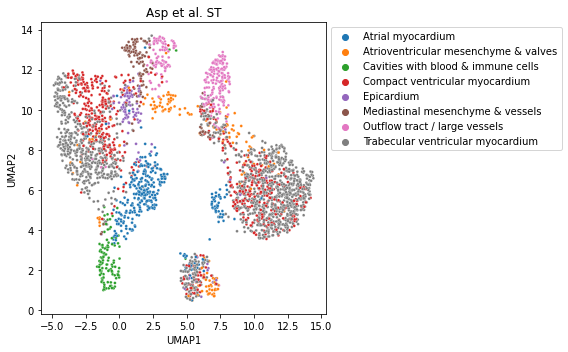

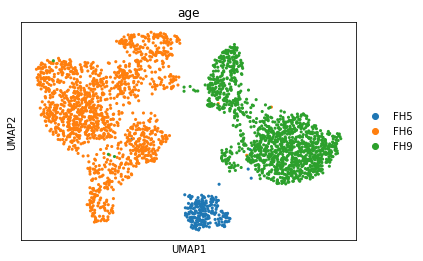

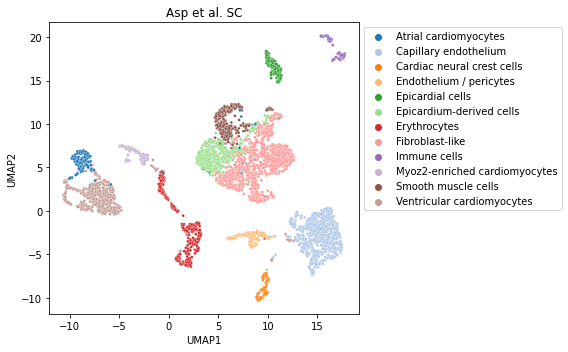

In [52]:
# asp_st
ds = 'asp_st'

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot['Anatomical regions'] = dic_data_proc[ds].obs['Anatomical regions']

plt.figure(figsize=[8,5])
sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Anatomical regions', palette='tab10', s=8)
plt.title(DIC_INFO[ds]['dname'])
plt.legend(bbox_to_anchor=[1,1])
plt.tight_layout()
plt.show()

temp_data = dic_data_proc['asp_st'].copy()
temp_data.obs['age'] = [x.split('_')[0] for x in temp_data.obs['Sample']]
temp_data.obs['age'] = temp_data.obs['age'].astype('category')
sc.pl.umap(temp_data, color='age')

# asp_sc
ds = 'asp_sc'

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot['celltype'] = dic_data_proc[ds].obs['celltype']

plt.figure(figsize=[8,5])
sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='celltype', palette='tab20', s=8)
plt.title(DIC_INFO[ds]['dname'])
plt.legend(bbox_to_anchor=[1,1])
plt.tight_layout()
plt.show()

PASS_AtrialFibrillation_Nielsen2018


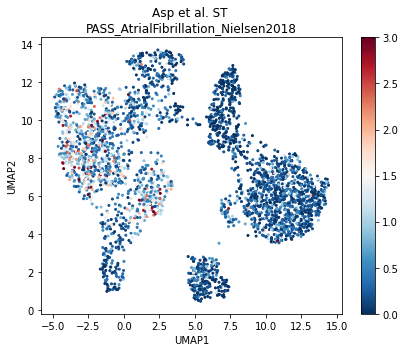

In [62]:
ds = 'asp_st'
trait_list_plot = dic_trait_assoc_list[ds]
trait_list_plot = ['PASS_AtrialFibrillation_Nielsen2018']

for trait in trait_list_plot:
    print(trait)
    plt.figure(figsize=[6,5])
        
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
    df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=3, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s \n%s'%(DIC_INFO[ds]['dname'], trait))
    
    plt.tight_layout()
    plt.show()

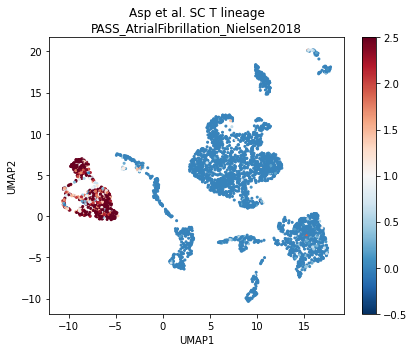

In [63]:
ds = 'asp_sc'
trait_list_plot = dic_trait_assoc_list[ds]
trait_list_plot = ['PASS_AtrialFibrillation_Nielsen2018']

for trait in trait_list_plot:
    plt.figure(figsize=[6,5])
        
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])
    df_plot['%s.nlog10_fdr'%trait] = -np.log10(df_plot['%s.fdr'%trait])

    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_fdr'%trait],
                cmap='RdBu_r', vmax=2.5, vmin=-0.5, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s T lineage\n%s'%(DIC_INFO[ds]['dname'], trait))
    
    plt.tight_layout()
    plt.show()

asp_st PASS_AtrialFibrillation_Nielsen2018


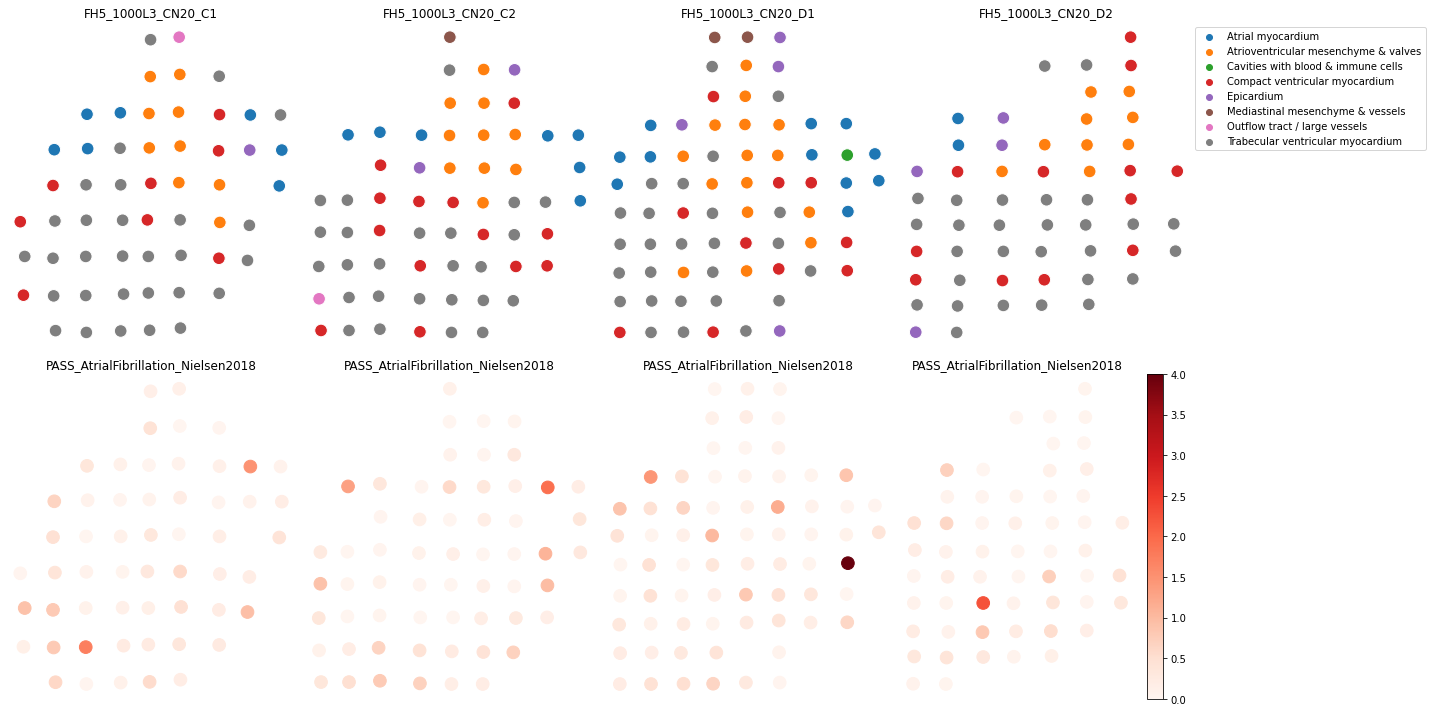

In [120]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = -df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

plt.figure(figsize=[20,10])
for i_sample, sample in enumerate(sorted([x for x in df_plot['Sample'].unique() if 'FH5' in x])):    
    ind_select = df_plot['Sample']==sample
    
    plt.subplot(2,4,i_sample+1)
    if i_sample==3:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.title(sample)
    plt.axis('off')        
    
    plt.subplot(2,4,i_sample+5)
    plt.scatter(df_plot.loc[ind_select, 'plot_x'], 
                df_plot.loc[ind_select, 'plot_y'],
                c=df_plot.loc[ind_select, '%s.nlog10_pval'%trait],
                cmap='Reds', vmax=4, vmin=0, s=160)
    
    plt.axis('off')
    plt.title(trait)    
    if i_sample==3:
        plt.colorbar()
    
plt.tight_layout()
plt.show()  

asp_st PASS_AtrialFibrillation_Nielsen2018


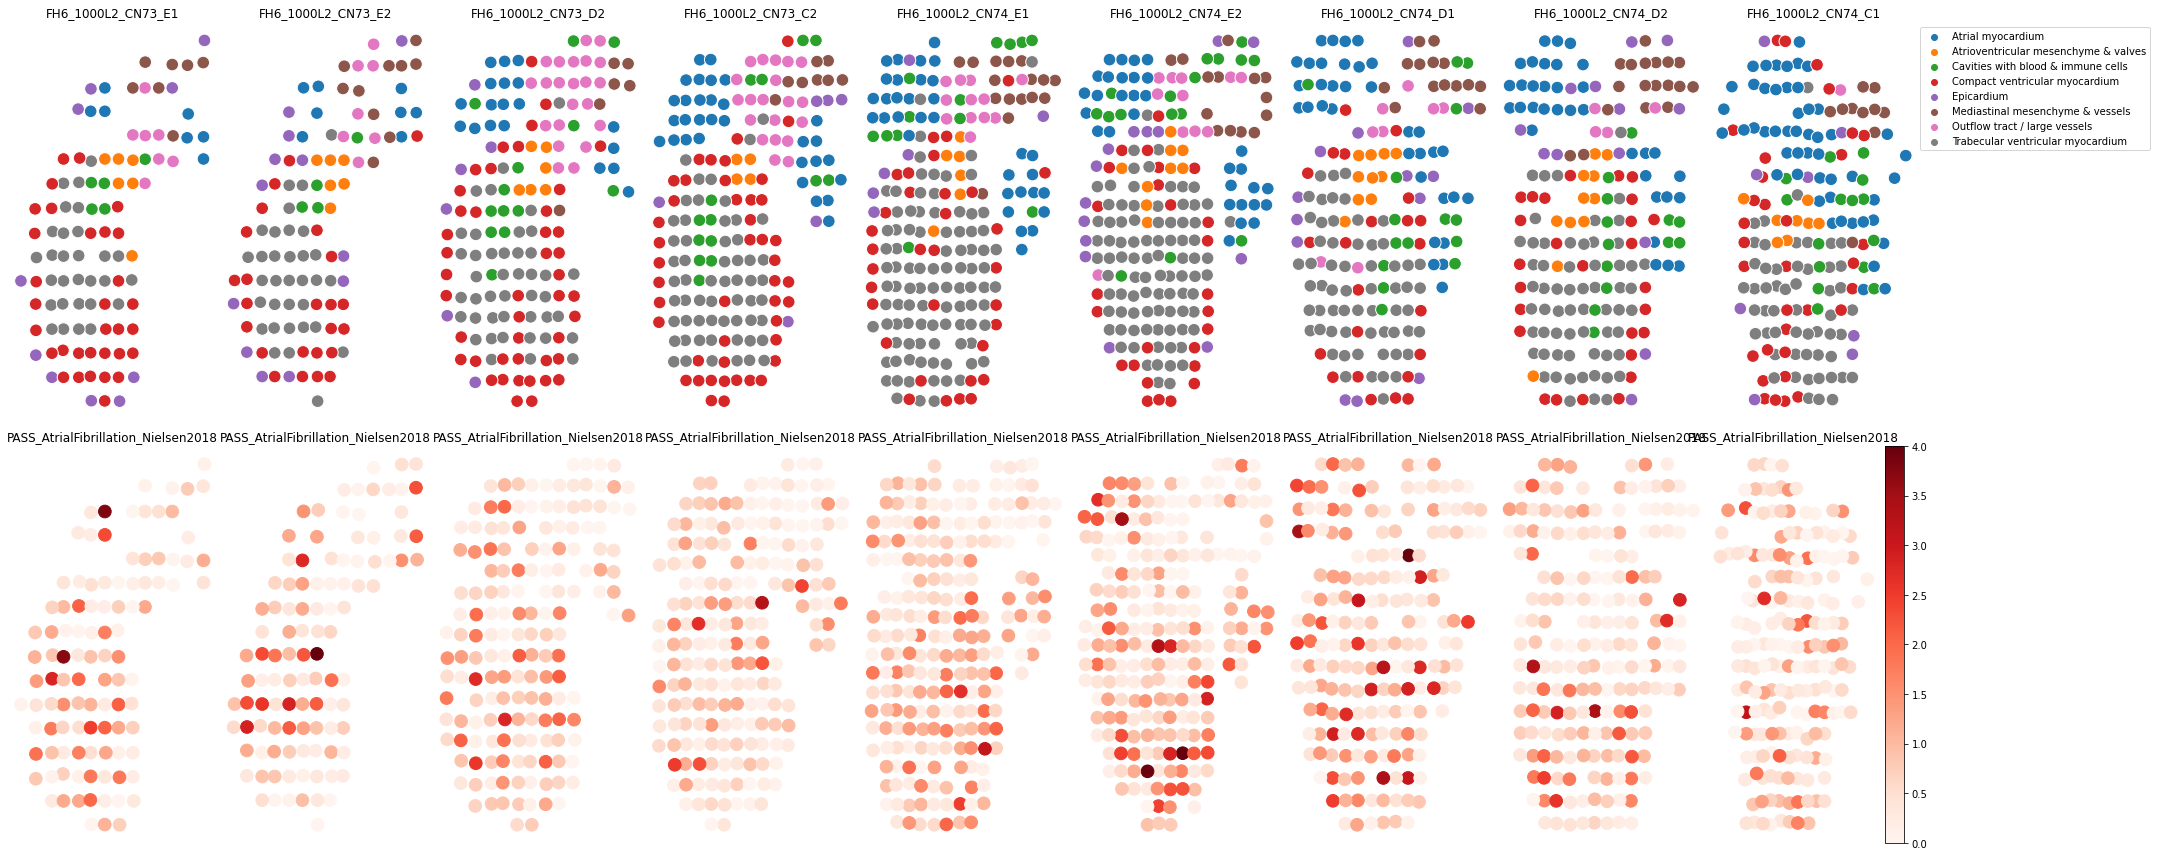

In [135]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

plt.figure(figsize=[30,12])
for i_sample, sample in enumerate(['FH6_1000L2_CN73_E1', 'FH6_1000L2_CN73_E2', 'FH6_1000L2_CN73_D2',
                                   'FH6_1000L2_CN73_C2', 'FH6_1000L2_CN74_E1', 'FH6_1000L2_CN74_E2', 
                                   'FH6_1000L2_CN74_D1', 'FH6_1000L2_CN74_D2', 'FH6_1000L2_CN74_C1']):    
    ind_select = df_plot['Sample']==sample
    
    plt.subplot(2,9,i_sample+1)
    if i_sample==8:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.title(sample)
    plt.axis('off')        
    
    plt.subplot(2,9,i_sample+10)
    plt.scatter(df_plot.loc[ind_select, 'plot_x'], 
                df_plot.loc[ind_select, 'plot_y'],
                c=df_plot.loc[ind_select, '%s.nlog10_pval'%trait],
                cmap='Reds', vmax=4, vmin=0, s=160)
    
    plt.axis('off')
    if i_sample==8:
        plt.colorbar()
    plt.title(trait)
    
plt.tight_layout()
plt.show()  

asp_st PASS_AtrialFibrillation_Nielsen2018


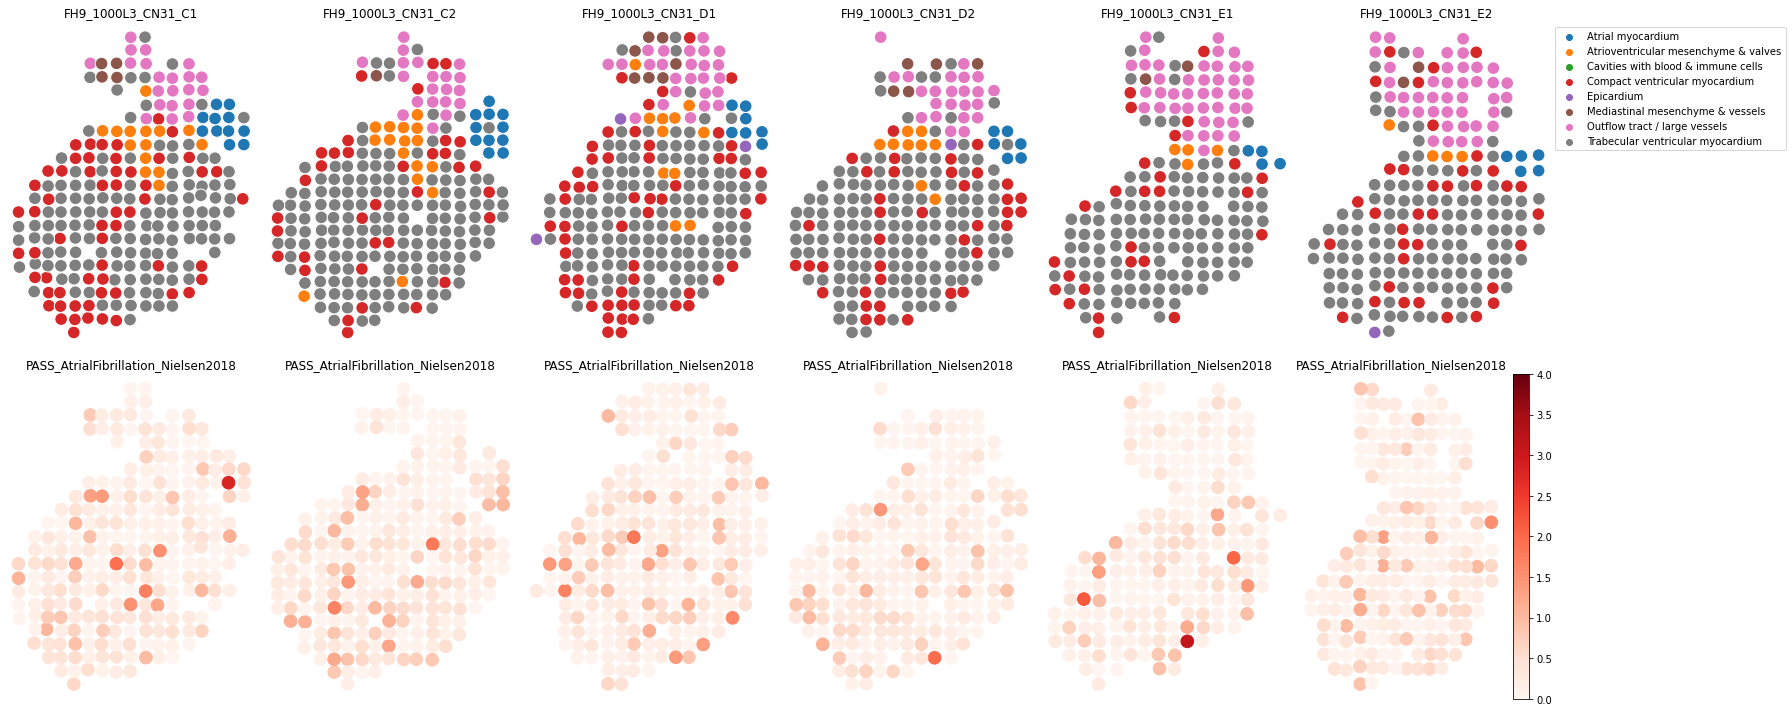

In [124]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

plt.figure(figsize=[25,10])
for i_sample, sample in enumerate(sorted([x for x in df_plot['Sample'].unique() if 'FH9' in x])):    
    ind_select = df_plot['Sample']==sample
    
    plt.subplot(2,6,i_sample+1)
    if i_sample==5:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.title(sample)
    plt.axis('off')        
    
    plt.subplot(2,6,i_sample+7)
    plt.scatter(df_plot.loc[ind_select, 'plot_x'], 
                df_plot.loc[ind_select, 'plot_y'],
                c=df_plot.loc[ind_select, '%s.nlog10_pval'%trait],
                cmap='Reds', vmax=4, vmin=0, s=160)
    
    plt.axis('off')
    plt.title(trait)    
    if i_sample==5:
        plt.colorbar()
    
plt.tight_layout()
plt.show()  

asp_st PASS_AtrialFibrillation_Nielsen2018


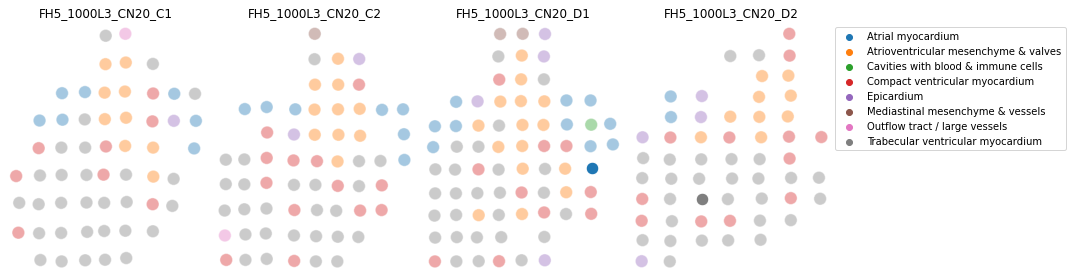

In [161]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = -df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])

plt.figure(figsize=[15,4])
for i_sample, sample in enumerate(sorted([x for x in df_plot['Sample'].unique() if 'FH5' in x])):    
    ind_select_sig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]<0.25)
    ind_select_nsig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]>0.25)
    
    plt.subplot(1,4,i_sample+1)
    sns.scatterplot(data=df_plot.loc[ind_select_nsig],
                    x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10',
                    s=160, legend=False, alpha=0.4)
    if i_sample==3:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.title(sample)
    plt.axis('off')   
    
plt.tight_layout()
plt.show()  

asp_st PASS_AtrialFibrillation_Nielsen2018


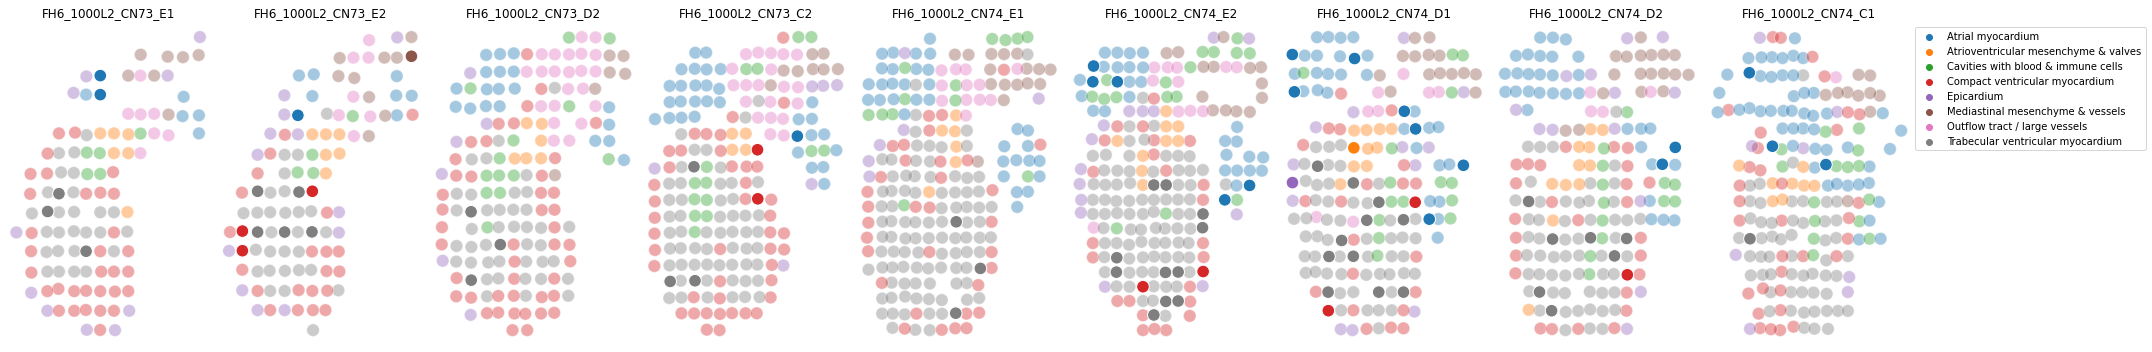

In [160]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])

plt.figure(figsize=[30,5])
for i_sample, sample in enumerate(['FH6_1000L2_CN73_E1', 'FH6_1000L2_CN73_E2', 'FH6_1000L2_CN73_D2',
                                   'FH6_1000L2_CN73_C2', 'FH6_1000L2_CN74_E1', 'FH6_1000L2_CN74_E2', 
                                   'FH6_1000L2_CN74_D1', 'FH6_1000L2_CN74_D2', 'FH6_1000L2_CN74_C1']):    
    ind_select_sig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]<0.25)
    ind_select_nsig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]>0.25)
    
    plt.subplot(1,9,i_sample+1)
    sns.scatterplot(data=df_plot.loc[ind_select_nsig],
                    x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10',
                    s=160, legend=False, alpha=0.4)
    if i_sample==8:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.title(sample)
    plt.axis('off')   
    
plt.tight_layout()
plt.show()  

asp_st PASS_AtrialFibrillation_Nielsen2018


No handles with labels found to put in legend.


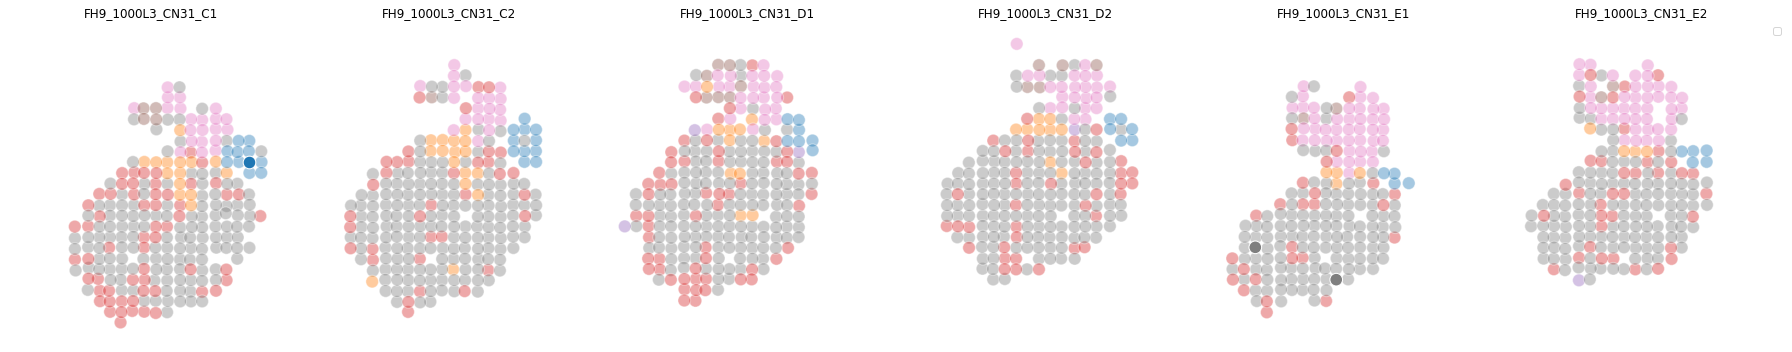

In [164]:
# Spatial information 
ds = 'asp_st'
trait = 'PASS_AtrialFibrillation_Nielsen2018'

print(ds, trait)

df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                       data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_data_raw[ds].obs[['Sample', 'new_x', 'new_y', 'Anatomical regions']])
df_plot['plot_x'] = df_plot['new_x']
df_plot['plot_y'] = df_plot['new_y']
df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])

plt.figure(figsize=[25,5])
for i_sample, sample in enumerate(sorted([x for x in df_plot['Sample'].unique() if 'FH9' in x])):    
    ind_select_sig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]<0.25)
    ind_select_nsig = (df_plot['Sample']==sample) & (df_plot['%s.fdr'%trait]>0.25)
    
    plt.subplot(1,6,i_sample+1)
    sns.scatterplot(data=df_plot.loc[ind_select_nsig],
                    x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10',
                    s=160, legend=False, alpha=0.4)
    if i_sample==5:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160)
        plt.legend(bbox_to_anchor=[1,1])    
    else:
        sns.scatterplot(data=df_plot.loc[ind_select_sig],
                        x='plot_x', y='plot_y', hue='Anatomical regions', palette='tab10', s=160, legend=False)
    plt.xlim([5,30])
    plt.ylim([0,30])
    plt.title(sample)
    plt.axis('off')   
    
plt.tight_layout()
plt.show()  